<a href="https://colab.research.google.com/github/Venu2791/Deep-Vision/blob/master/Assignment%206/Assignment_6B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Problem Statement:**

This part of the assignment is to use the different convolutions in the order given below:</br>

> Normal Convolution</br>
> Spatially Separable Convolution  (Conv2d(x, (3,1)) followed by Conv2D(x,(3,1))</br>
> Depthwise Separable Convolution</br>
> Grouped Convolution (use 3x3, 5x5 only)</br>
> Grouped Convolution (use 3x3 only, one with dilation = 1, and another with dilation = 2)</br>

Use funtional API to build the model with all of the 5 above at least once and Train this new model for 50 epochs. 


In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

**Loading and Pre-Processing the Data:**

Number of classes : 10
Training set size : 50K
Test set size : 10K
Image resolution : 32x32


In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 6s 0us/step


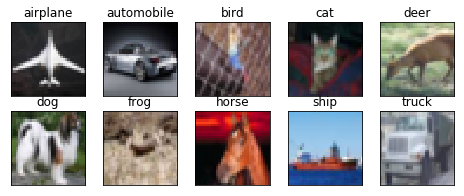

In [0]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

**Plot Model history:**

This function plots the loss and accuracy for both train and validation datasets. The values for the fucntion are the history returned from the fit_generator fucntion. 

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

##Test Accuracy:
With the trained model, we do the predictions for the test dataset using predict function. We then compute the accuracy.

Accuracy= # of correct predictions/number of samples.

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

**Pre-processing:**</br>
Convert the image to float.</br>
Standardising the train and test data set by dividing it by 255.</br>
Convert the labels to one hot encoding.</br>

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

### Architecture of the model:

32X32X3    |  3X3X3X32         | 32X32X32    GRF-3  </br>
32X32X32   |  3X3X32X64        | 32X32X64    GRF-5  </br>
32X32X64   |  3X3X64X128       | 32X32X128   GRF-7</br>
32X32X128  | maxpooling(2,2)   | 16X16X128   GRF-8</br>
16X16X128  |  1X1X128X32       | 16X16X32    GRF-8</br> 
16X16X32   |  3X3X32X64        | 16X16X64    GRF-12</br>
16X16X64   |  3X3X64X128       | 16X16X128   GRF-16</br>
16X16X128  | maxpooling(2,2)   | 8X8X128     GRF-18</br>
8X8X128    |  1X1X128X32       | 8X8X32      GRF-18</br>
8X8X32     |  3X3X32X64        | 8X8X64      GRF-26</br>
8X8X64     |  8X8X64X10        | 8X8X10      GRF-34</br>
8X8X128    |  7X7X10X10        | 2X2X10      GRF-34</br>
2X2X10     |  GlobalAvgPooling | 1X1X10

In [0]:
# Define the model
model = Sequential()
model.add(Convolution2D(48, 3, 3, border_mode='same', input_shape=(32, 32, 3)))
model.add(Activation('relu'))
model.add(Convolution2D(48, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Convolution2D(96, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(Convolution2D(96, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Convolution2D(192, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(Convolution2D(192, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (3, 3), input_shape=(32, 32, 3..., padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (3, 3))`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(96, (3, 3), padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(96, (3, 3))`
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(192, (3, 3), padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` 

In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_61 (Conv2D)           (None, 32, 32, 48)        1344      
_________________________________________________________________
activation_4 (Activation)    (None, 32, 32, 48)        0         
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 30, 30, 48)        20784     
_________________________________________________________________
activation_5 (Activation)    (None, 30, 30, 48)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 15, 15, 48)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 48)        0         
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 15, 15, 96)       

***Data Augumentation:***

We use certain techniques with data augumentation: Image Standardization, Normalization and Horizontal Flip.

we use the fit_generator

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=50)`
  if sys.path[0] == '':




Epoch 1/50
390/390 [==============================] - 30s 78ms/step - loss: 1.8807 - acc: 0.2726 - val_loss: 1.5554 - val_acc: 0.4241
Epoch 2/50
390/390 [==============================] - 21s 54ms/step - loss: 1.4010 - acc: 0.4900 - val_loss: 1.1467 - val_acc: 0.5815
Epoch 3/50
390/390 [==============================] - 22s 55ms/step - loss: 1.1391 - acc: 0.5968 - val_loss: 0.9536 - val_acc: 0.6629
Epoch 4/50
390/390 [==============================] - 21s 53ms/step - loss: 0.9849 - acc: 0.6549 - val_loss: 0.8342 - val_acc: 0.7138
Epoch 5/50
390/390 [==============================] - 20s 52ms/step - loss: 0.8593 - acc: 0.7016 - val_loss: 0.7927 - val_acc: 0.7241
Epoch 6/50
390/390 [==============================] - 21s 54ms/step - loss: 0.7837 - acc: 0.7317 - val_loss: 0.7176 - val_acc: 0.7553
Epoch 7/50
390/390 [==============================] - 22s 55ms/step - loss: 0.7316 - acc: 0.7512 - val_loss: 0.6978 - val_acc: 0.7650
Epoch 8/50
390/390 [==============================] - 21s 54

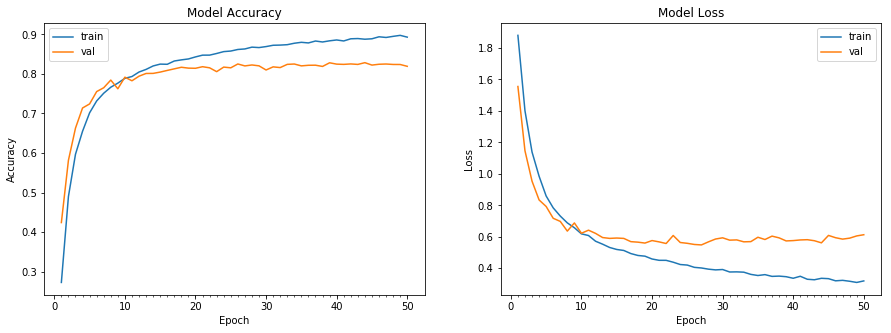

Accuracy on test data is: 81.92


In [0]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 50, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

In [0]:
#Model
from keras.layers.convolutional import Conv2D,SeparableConv2D,DepthwiseConv2D
from keras.layers.pooling import MaxPooling2D,GlobalAveragePooling2D
from keras.models import Model
from keras.layers import Input,add, Activation
from keras.layers.merge import concatenate
from keras.layers.normalization import BatchNormalization
from keras.utils import plot_model

**Model Architecture:**

We have defined the model in 3 blocks: </br>

Block 1 with vanilla 3X3 and spatially separable Convolutions.</br>
Block2 consists depthwise convolution and grouped convolutions.</br>
Block 3 consists of dialated convolution, after this we use few convolution layers and GAP before softmax.

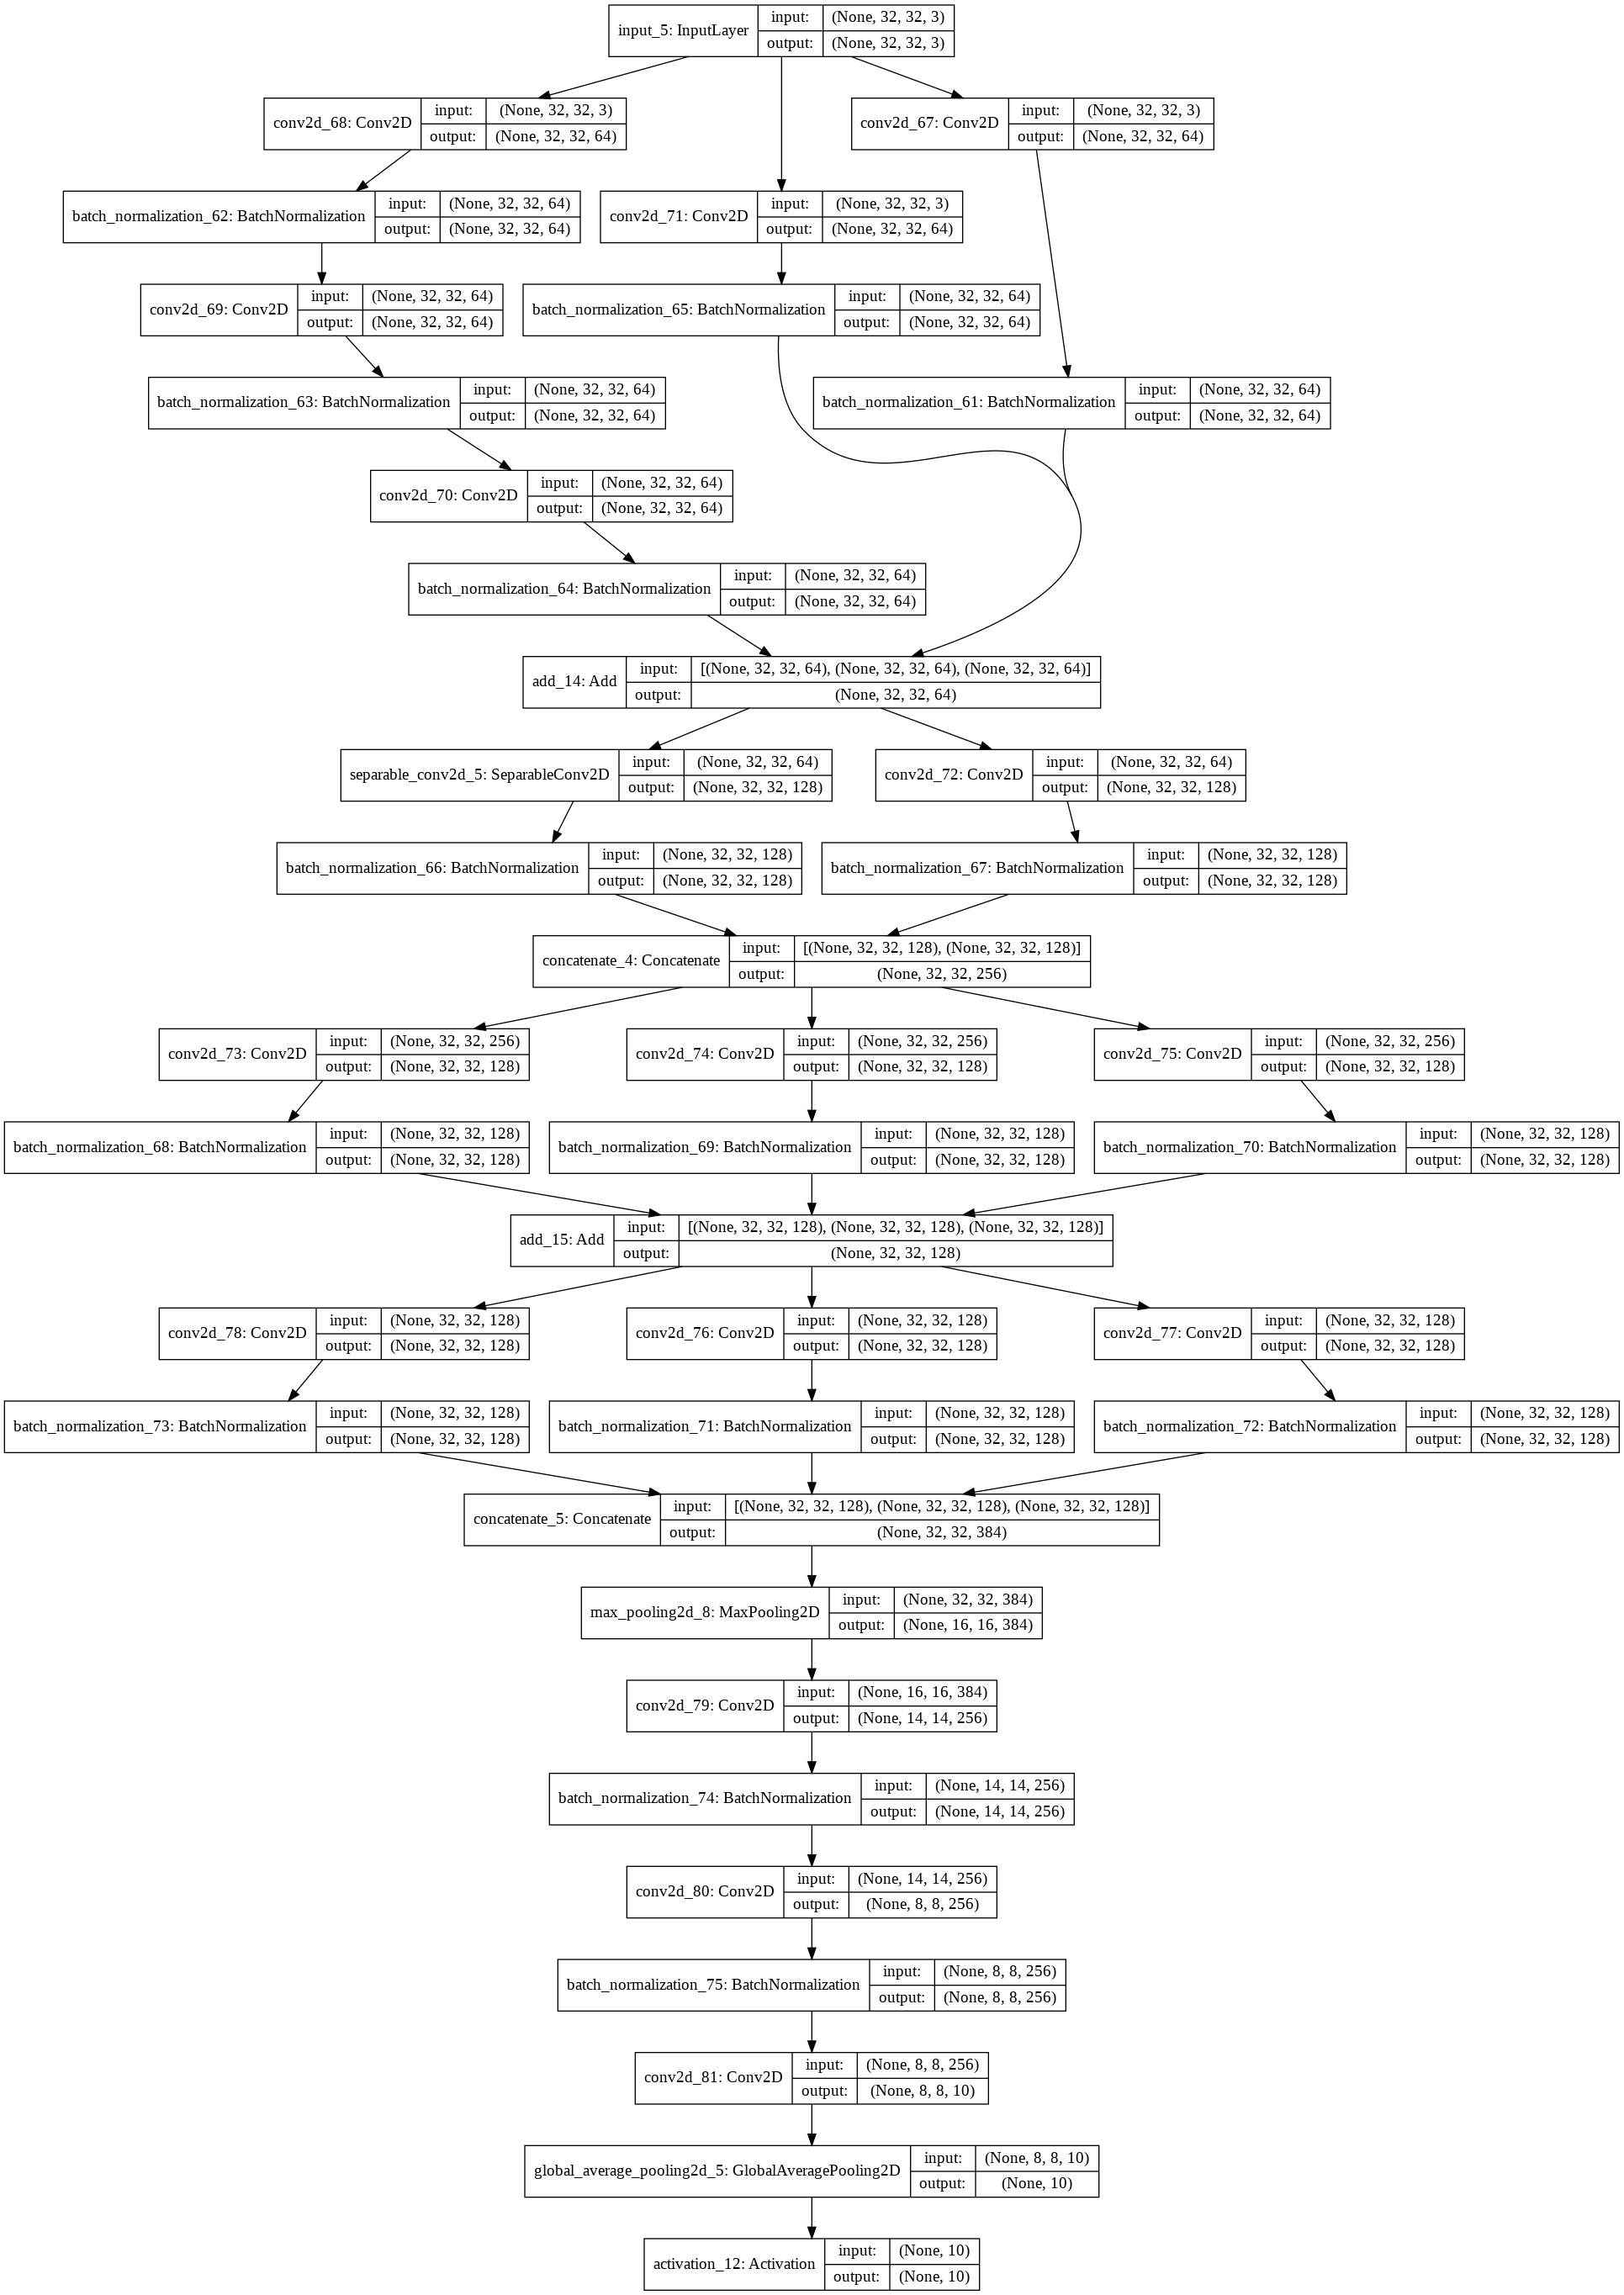

In [0]:
input_img= Input(shape=(32,32,3))
#block 1
conv_1=Conv2D(64,(3,3),activation="relu",padding="same")(input_img)
BN_1=BatchNormalization()(conv_1)
conv_2=Conv2D(64,(1,1),activation="relu")(input_img)
BN_2=BatchNormalization()(conv_2)
spacsep1=Conv2D(64,(3,1),activation="relu",padding="same")(BN_2)
BN_3=BatchNormalization()(spacsep1)
spacsep2=Conv2D(64,(1,3),activation="relu",padding="same")(BN_3)
BN_4=BatchNormalization()(spacsep2)
layer1=Conv2D(64,(1,1),activation="relu")(input_img)
BN2=BatchNormalization()(layer1)
layer_1=add([BN2,BN_1,BN_4])

#Block2
depthconv=SeparableConv2D(128,(3,3),activation="relu",padding="Same")(layer_1)
BN_6=BatchNormalization()(depthconv)
layer_2=Conv2D(128,(1,1),activation="relu")(layer_1)
BN_7=BatchNormalization()(layer_2)
depthwiseconv=concatenate([BN_6,BN_7])

groupedconv1= Conv2D(128,(3,3),activation="relu",padding="same")(depthwiseconv)
BN_8=BatchNormalization()(groupedconv1)
groupedconv2=Conv2D(128,(5,5),activation="relu",padding="same")(depthwiseconv)
BN_9=BatchNormalization()(groupedconv2)
groupedconv3=Conv2D(128,(1,1),activation="relu",padding="same")(depthwiseconv)
BN_10=BatchNormalization()(groupedconv3)
layer_2=add([BN_8,BN_9,BN_10])

#Block3
conv_3=Conv2D(128,(3,3),padding="same",dilation_rate=(2,2),activation="relu")(layer_2)
BN_11=BatchNormalization()(conv_3)
conv_4=Conv2D(128,(3,3),activation="relu",padding="same")(layer_2)
BN_12=BatchNormalization()(conv_4)
layer2=Conv2D(128,(1,1),activation="relu")(layer_2)
BN_13=BatchNormalization()(layer2)
dialatedconv=concatenate([BN_13,BN_11,BN_12])

pool=MaxPooling2D(pool_size=(2,2))(dialatedconv)

conv_7=Conv2D(256,(3,3),activation="relu")(pool)
BN_16=BatchNormalization()(conv_7)

conv_6=Conv2D(256,(7,7),activation="relu")(BN_16)
BN_15=BatchNormalization()(conv_6)
conv_8=Conv2D(10,(1,1),activation="relu")(BN_15)
Dout=GlobalAveragePooling2D()(conv_8)


output=Activation("softmax")(Dout)

model = Model(inputs=input_img, outputs=output)

plot_model(model, show_shapes=True,rankdir='TB',dpi=96)

##Training the given model:

In the below code, we use DataGenerator objects to train the model in batches (batch_size=128) for 100 epochs.
We plot the accuracy and losses on the training and test sets after each epoch.
We normalize the image and use horizontal flip

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=97, epochs=15)`
  del sys.path[0]


Epoch 1/15


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


97/97 [==============================] - 256s 3s/step - loss: 1.5233 - acc: 0.4729 - val_loss: 1.3586 - val_acc: 0.5338
Epoch 2/15
97/97 [==============================] - 222s 2s/step - loss: 0.9220 - acc: 0.6787 - val_loss: 1.1826 - val_acc: 0.5828
Epoch 3/15
97/97 [==============================] - 222s 2s/step - loss: 0.6568 - acc: 0.7728 - val_loss: 0.8363 - val_acc: 0.7122
Epoch 4/15
97/97 [==============================] - 222s 2s/step - loss: 0.5138 - acc: 0.8256 - val_loss: 0.6452 - val_acc: 0.7828
Epoch 5/15
97/97 [==============================] - 222s 2s/step - loss: 0.4204 - acc: 0.8595 - val_loss: 0.5681 - val_acc: 0.8030
Epoch 6/15
97/97 [==============================] - 222s 2s/step - loss: 0.3477 - acc: 0.8831 - val_loss: 0.5652 - val_acc: 0.8119
Epoch 7/15
97/97 [==============================] - 223s 2s/step - loss: 0.2875 - acc: 0.9046 - val_loss: 0.5720 - val_acc: 0.8110
Epoch 8/15
97/97 [==============================] - 223s 2s/step - loss: 0.2363 - acc: 0.9225 

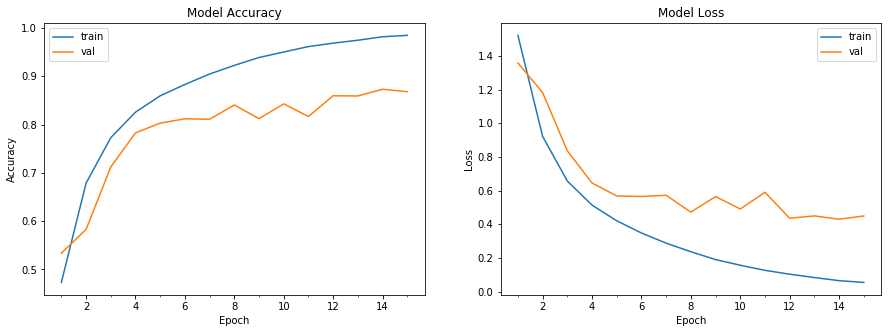

Accuracy on test data is: 86.81


In [0]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,zoom_range=0.0, 
                             horizontal_flip=True)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 512),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 15, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))